In [1]:
import os
print(os.getcwd())  # check local
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse


/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [120]:
exp_name = 'pre_industrial'
exp_path = f'/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/theory_adiabat/above_quant_2m_500hPa/{exp_name}/all_days/output_lev_quant95.nd2'
lat_min = 40
lat_max = 65
ds = xr.open_dataset(exp_path).sel(lat=slice(lat_min, lat_max)).isel(quant=0)

In [121]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.open_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['LANDFRAC', 'PHIS']]
invariant_data = invariant_data.reindex_like(ds['PS'], method="nearest", tolerance=0.01).load()
# lsm = lsm_zhang
land = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']>0.5)*0+1
ocean = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']<=0.5)*0+1
weights = np.cos(np.deg2rad(invariant_data.lat))
z2m = invariant_data.PHIS/g + 2

In [187]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180,180.01,60), grid_lat=np.asarray([40, 65])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0
    return ax

def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=land, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

In [122]:
mask = np.logical_and(z2m < 1000, land>0)       # only consider land regions less than 1km in height
# mask = land > 0
ds = ds.where(mask).load()

In [123]:
# Account for regions where LCL outside the range between REFHT and pressure_ft
pressure_ft = 500 * 100
# Replace T_at_lcl with TREFHT wherever p_at_lcl closer to surface than PREFHT
ds['T_at_lcl'] = ds['T_at_lcl'].where(ds.p_at_lcl < ds.PREFHT, ds.TREFHT)
ds['T_at_lcl'] = ds['T_at_lcl'].where(ds.p_at_lcl > pressure_ft, ds.T_zonal_av+ds.T_anom)         # where p_at_lcl further from surface than FT, set to FT
# Do same with p_at_lcl
ds['p_at_lcl'] = ds['p_at_lcl'].where(ds.p_at_lcl < ds.PREFHT, ds.PREFHT)
ds['p_at_lcl'] = ds['p_at_lcl'].where(ds.p_at_lcl > pressure_ft, pressure_ft)

In [124]:
ds['lapse_below_lcl'] = get_bulk_lapse_rate(ds.TREFHT, ds.T_at_lcl, ds.PREFHT, ds.p_at_lcl) * 1000
ds['lapse_below_lcl'] = ds['lapse_below_lcl'].where(ds.p_at_lcl < ds.PREFHT, 0)         # set to 0 where p_at_lcl = PREFHT
ds['lapse_above_lcl'] = get_bulk_lapse_rate(ds.T_at_lcl, ds.T_zonal_av+ds.T_anom, ds.p_at_lcl, pressure_ft) * 1000
ds['lapse_above_lcl'] = ds['lapse_above_lcl'].where(ds.p_at_lcl > pressure_ft, 0)         # set to 0 where p_at_lcl = pressure_ft

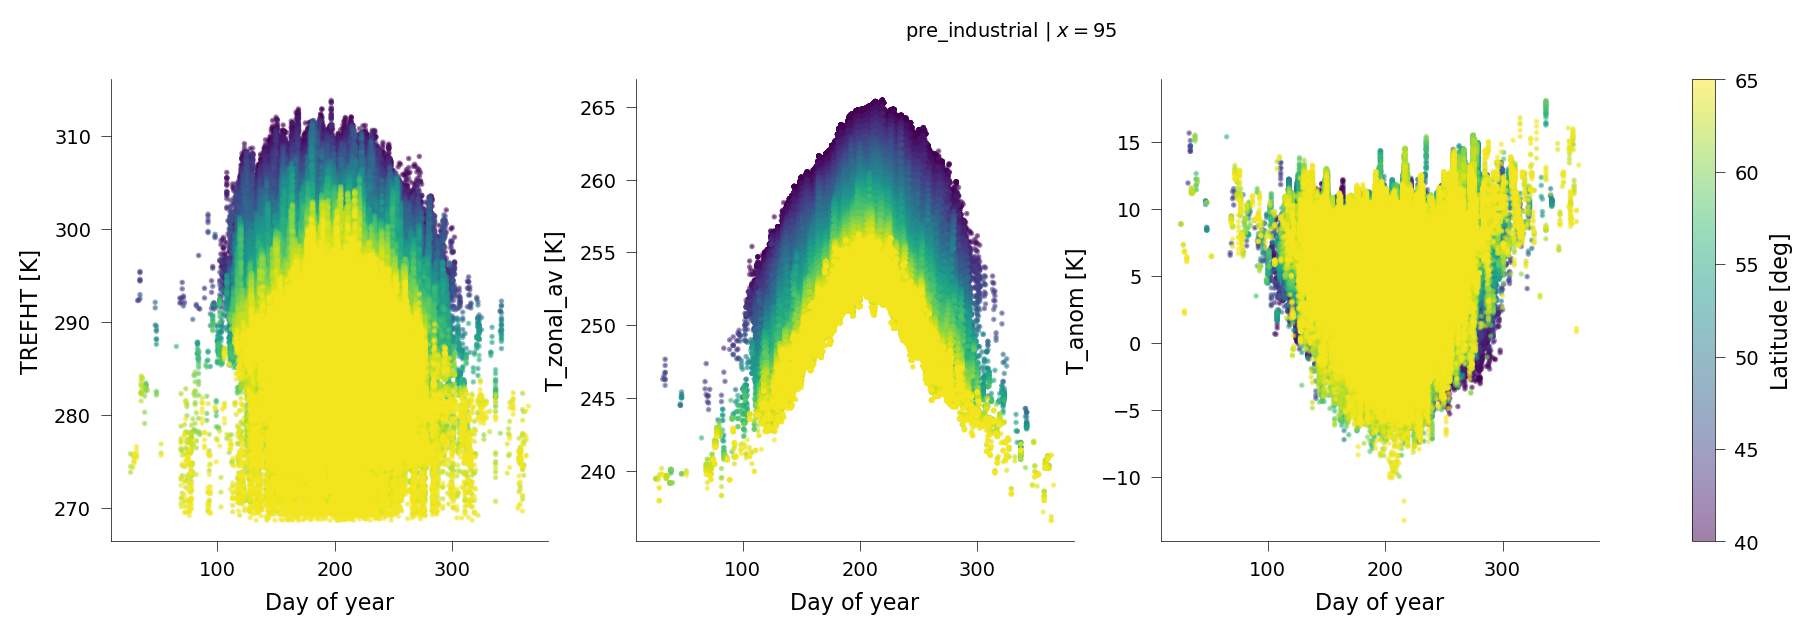

In [20]:
fig, ax = plt.subplots(1, 3, sharex=True)
fig_resize(fig, 4*3)
ax[0].scatter(ds.dayofyear, ds.TREFHT, s=1, c=ds.dayofyear*0+ds.lat, alpha=0.5, vmin=lat_min, vmax=lat_max)
ax[1].scatter(ds.dayofyear, ds.T_zonal_av, s=1, c=ds.dayofyear*0+ds.lat, alpha=0.5, vmin=lat_min, vmax=lat_max)
im = ax[2].scatter(ds.dayofyear, ds.T_anom, s=1, c=ds.dayofyear*0+ds.lat, alpha=0.5, vmin=lat_min, vmax=lat_max)
plt.colorbar(im, ax=ax.ravel(), label='Latitude [deg]')
ax[0].set_xlabel('Day of year')
ax[1].set_xlabel('Day of year')
ax[2].set_xlabel('Day of year')
ax[0].set_ylabel('TREFHT [K]')
ax[1].set_ylabel('T_zonal_av [K]')
ax[2].set_ylabel('T_anom [K]')
fig.suptitle(f"{exp_name} | $x={ds.quant:.0f}$")
plt.show()

In [199]:
var_pca = ['T_zonal_av', 'T_anom', 'lapse_below_lcl', 'lapse_above_lcl', 'p_at_lcl', 'PREFHT']
keep_ind = np.where(~np.isnan(ds.T_zonal_av.values.flatten()))[0]
X = np.column_stack([ds[key].values.flatten() for key in var_pca])
X[:, -2] /= X[:, -1]                    # normalise LCL by PREFHT
X[:, -1] = pressure_ft / X[:, -1]       # set PREFHT to pressure_ft / PREFHT
X = X[:, :-1]           # ignore PREFHT in finding principal components

In [208]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = np.full_like(X, np.nan)
X_scaled[keep_ind] = scaler.fit_transform(X[keep_ind])

In [214]:
n_comp = 3
pca = PCA(n_components=n_comp)
X_pca = np.full((X.shape[0], n_comp), np.nan)
X_pca[keep_ind] = pca.fit_transform(X_scaled[keep_ind])

In [232]:
j=128
np.where(np.logical_and(np.abs(X_lat-ds.lat.values[i])<0.1, np.abs(X_lon-ds.lon.values[j])<0.1))[0]

array([], dtype=int64)

In [217]:
np.where(np.logical_and(X_lat==ds.lat.values[i], X_lon==ds.lon.values[i]))

(array([], dtype=int64),)

In [233]:
X_pca_grid = np.full((ds.lat.size, ds.lon.size, ds.sample.size, n_comp), np.nan)
for i in range(ds.lat.size):
    for j in range(ds.lon.size):
        ind = np.where(np.logical_and(np.abs(X_lat-ds.lat.values[i])<0.1, np.abs(X_lon-ds.lon.values[j])<0.1))[0]
        if len(ind) == 0:
            continue
        X_pca_grid[i, j, :len(ind)] = X_pca[ind]

In [235]:
da_pca = xr.DataArray(
    X_pca_grid,
    dims=('lat', 'lon', 'sample', 'pc'),
    coords={'lat': ds.lat, 'lon': ds.lon, 'sample': ds.sample, 'pc': np.arange(n_comp)},
    name='pc_coef'
)

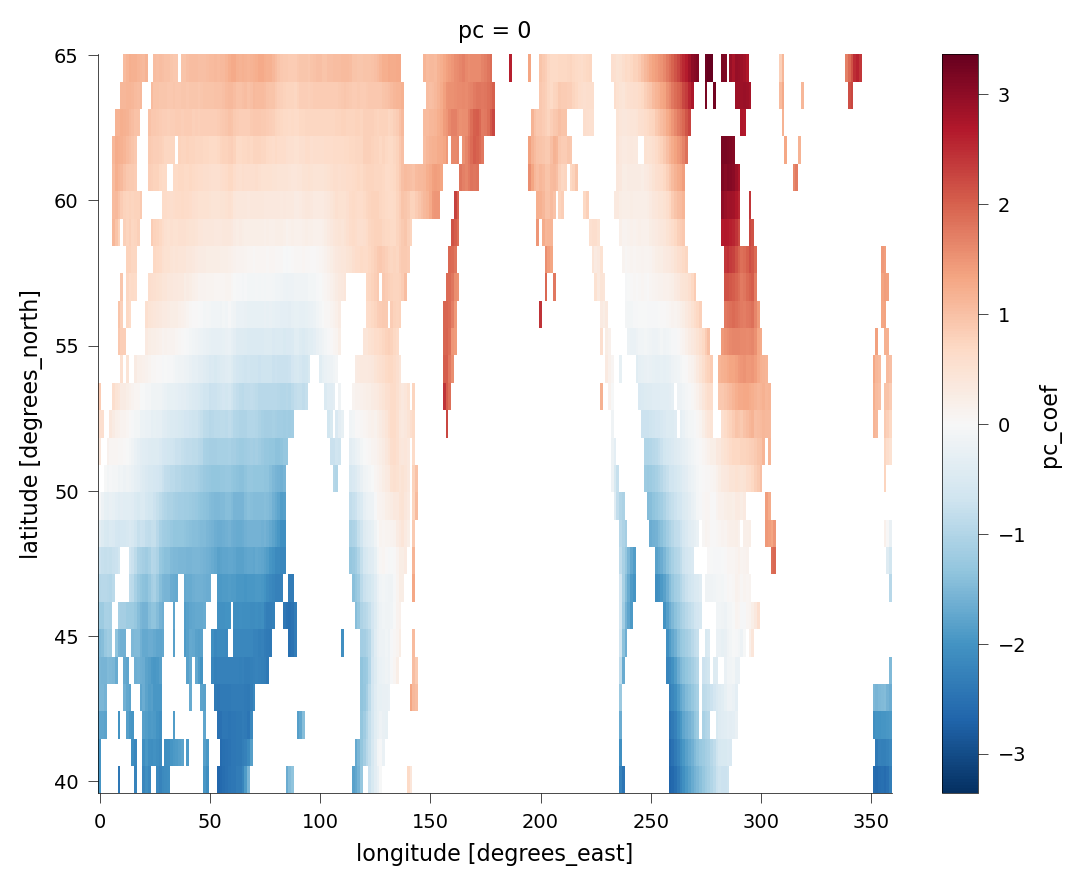

In [236]:
da_pca.mean(dim='sample').isel(pc=0).plot()

In [210]:
pca.explained_variance_ratio_

array([0.41009393, 0.21902956, 0.16708213])

In [220]:
X_lat = (0*ds.dayofyear + ds.lat).values.flatten()
X_lon = (0*ds.dayofyear +ds.lon).values.flatten()
X_trefht = ds.TREFHT.values.flatten()

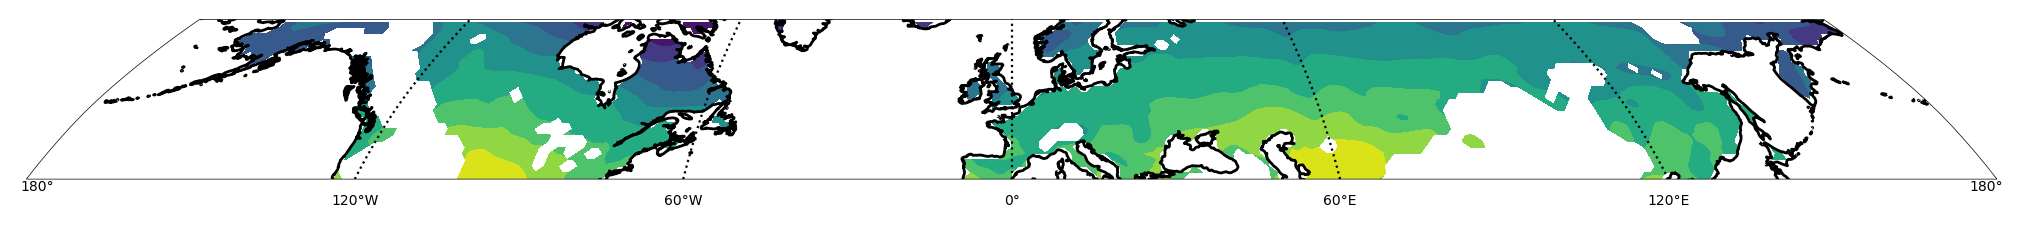

In [191]:
show_plot_loc = True
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax, lat_min=lat_min, lat_max=lat_max)
plot_contour_projection(ax, ds.TREFHT.mean(dim='sample'))
proj = ccrs.PlateCarree(central_longitude=180)
# fig, ax = plt.subplots(1, 1, subplot_kw={'projection': proj})
# ax.pcolormesh(ds.lon, ds.lat, ds.TREFHT.mean(dim='sample'), transform=ccrs.PlateCarree())
# ax.set_extent([0, 360, lat_min, lat_max], crs=ccrs.PlateCarree())
# def lon_formatter(x, pos):
#     """Format longitudes from 0 to 360 without E/W"""
#     x = x % 360  # wrap into 0–360
#     return f"{int(x)}°"
# gl.xformatter = FuncFormatter(lon_formatter)
# gl.yformatter = cticker.LatitudeFormatter()
# ax.scatter(lon_plot, lat_plot, s=50, marker='.', c='r', lw=3, alpha=1, transform=ccrs.PlateCarree())
if show_plot_loc:
    plt.show()
else:
    plt.close()

In [206]:
plot_ind = np.logical_and(np.abs(X_lat-50)>0.1, np.abs(X_lon-30)>0)
# im = plt.scatter(X_pca[plot_ind, 0], X_pca[plot_ind, 1], c=X_lon[plot_ind], cmap='twilight', vmin=0, vmax=360, s=1)
im = plt.scatter(X_pca[plot_ind, 0], X_pca[plot_ind, 1], c=X_trefht[plot_ind], s=1)
plt.colorbar(im)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4261248 but corresponding boolean dimension is 1981559

In [211]:
loadings = pca.components_.T  # shape: (variables, components)

for i, pc_loadings in enumerate(loadings.T, 1):
    print(f"\nPC{i} loadings:")
    for var, loading in zip(var_pca, pc_loadings):
        print(f"  {var:20s}: {loading:.2f}")


PC1 loadings:
  T_zonal_av          : -0.42
  T_anom              : 0.41
  lapse_below_lcl     : -0.42
  lapse_above_lcl     : -0.42
  p_at_lcl            : 0.54

PC2 loadings:
  T_zonal_av          : 0.56
  T_anom              : -0.57
  lapse_below_lcl     : -0.43
  lapse_above_lcl     : -0.22
  p_at_lcl            : 0.35

PC3 loadings:
  T_zonal_av          : -0.16
  T_anom              : 0.01
  lapse_below_lcl     : -0.58
  lapse_above_lcl     : 0.80
  p_at_lcl            : 0.04
